In [1]:
!pip install vaderSentiment
!pip install scikit-surprise
!pip install folium
!pip install surprise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2457393 sha256=889f02dc160bfdb727a10aa87a7150087b6beb3d4941ba343f92b5b72fe00be2
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
!pip install "numpy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Recommendation system
from surprise import Reader, Dataset, SVD, accuracy, BaselineOnly, SlopeOne
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

# Utilities
import joblib
import random

# Plotting config
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Load Datasets**

In [169]:
# load listings
listings_df = pd.read_csv('listings (1).csv.gz', compression='gzip')
listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,44077,https://www.airbnb.com/rooms/44077,20250613040039,2025-06-13,city scrape,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,...,4.93,4.68,4.82,NaN,f,2,0,2,0,2.19
1,85156,https://www.airbnb.com/rooms/85156,20250613040039,2025-06-13,city scrape,Cosy Comfortable Irish Cottage 1 Double Bed,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",https://a0.muscache.com/pictures/1749253/9ed2a...,193005,...,4.89,4.64,4.78,NaN,f,2,0,2,0,2.00
2,159889,https://www.airbnb.com/rooms/159889,20250613040039,2025-06-13,city scrape,Friendly Single Room,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,https://a0.muscache.com/pictures/3031697/a8259...,766611,...,4.87,4.65,4.71,NaN,f,3,0,3,0,2.79
3,162809,https://www.airbnb.com/rooms/162809,20250613040039,2025-06-13,previous scrape,5.5 miles south of Dublin City :^),A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",https://a0.muscache.com/pictures/86694529/c07b...,777681,...,4.97,4.78,4.85,NaN,f,2,0,2,0,3.22
4,165828,https://www.airbnb.com/rooms/165828,20250613040039,2025-06-13,city scrape,Pádraig Pearse apt. Kilmainham,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",https://a0.muscache.com/pictures/34311419/b3f6...,790601,...,4.77,4.40,4.56,NaN,f,4,4,0,0,0.51


In [170]:
#drop null
listings_df.dropna(subset=['reviews_per_month'], inplace=True)

In [171]:
# load reviews
reviews_df = pd.read_csv('reviews.csv.gz', compression='gzip')
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,44077,203703,2011-03-20,393348,Christian,We enjoyed our stay very much. The room was co...
1,44077,211369,2011-03-28,444004,Solidea,We have been here 4 nights. Stay in a home is ...
2,44077,234215,2011-04-21,465058,Michael And Isabelle,Teresa and Hughie were great hosts. They were ...
3,44077,261843,2011-05-13,490005,Weston,"No surprises, was as described. Very gracious..."
4,44077,268148,2011-05-17,520460,Barbara,"Teresa was a lovely hostess, and we had a deli..."


In [172]:
reviews_df.isna().sum()

,0
listing_id,0
id,0
date,0
reviewer_id,0
reviewer_name,0
comments,28


In [173]:
reviews_df.dropna(inplace=True)

**Merging both datasets**

In [174]:
dublin_merged_df = pd.merge(listings_df, reviews_df, left_on='id', right_on='listing_id')
dublin_merged_df.head(2)

,id_x,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,listing_id,id_y,date,reviewer_id,reviewer_name,comments
0,44077,https://www.airbnb.com/rooms/44077,20250613040039,2025-06-13,city scrape,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,...,0,2,0,2.19,44077,203703,2011-03-20,393348,Christian,We enjoyed our stay very much. The room was co...
1,44077,https://www.airbnb.com/rooms/44077,20250613040039,2025-06-13,city scrape,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,...,0,2,0,2.19,44077,211369,2011-03-28,444004,Solidea,We have been here 4 nights. Stay in a home is ...


In [175]:
dublin_merged_df.duplicated().sum()

0

**Feature Engineering**

In [176]:
# Make the average of the ratings columns to just 1 column named 'avg_rating'
# columns to average
rating_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin', 'review_scores_communication',
                  'review_scores_location', 'review_scores_value']

# Create new column 'avg_rating' which is the row-wise mean of the selected columns
dublin_merged_df['avg_rating'] = dublin_merged_df[rating_columns].mean(axis=1)

In [177]:
# drop unnecessary columns in `dublin_merged_df`
# Left the host_since and first_review and last_review for now because we will need it for exploratory data analysis
columns_to_drop = [
    'scrape_id', 'last_scraped', 'source', 'host_url', 'host_name',
    'host_location', 'host_about', 'host_acceptance_rate', 'host_thumbnail_url',
    'host_picture_url', 'host_neighbourhood', 'host_has_profile_pic',
    'neighbourhood_group_cleansed', 'minimum_nights', 'maximum_nights',
    'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'calendar_updated', 'has_availability', 'availability_30', 'availability_60',
    'availability_90', 'availability_365', 'calendar_last_scraped',
    'number_of_reviews_ltm', 'number_of_reviews_l30d', 'license',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'reviews_per_month', 'listing_id', 'id_y', 'reviewer_name',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Drop the specified columns
dublin_merged_df = dublin_merged_df.drop(columns=columns_to_drop)

In [178]:
# check remaining columns
dublin_merged_df.columns

Index(['id_x', 'listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'number_of_reviews', 'availability_eoy', 'number_of_reviews_ly',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'first_review',
       'last_review', 'instant_bookable', 'date', 'reviewer_id', 'comments',
       'avg_rating'],
      dtype='object')

In [179]:
dublin_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310100 entries, 0 to 310099
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id_x                       310100 non-null  int64  
 1   listing_url                310100 non-null  object 
 2   name                       310100 non-null  object 
 3   description                305872 non-null  object 
 4   neighborhood_overview      207249 non-null  object 
 5   picture_url                310100 non-null  object 
 6   host_id                    310100 non-null  int64  
 7   host_since                 309837 non-null  object 
 8   host_response_time         291204 non-null  object 
 9   host_response_rate         291204 non-null  object 
 10  host_is_superhost          300605 non-null  object 
 11  host_listings_count        309837 non-null  float64
 12  host_total_listings_count  309837 non-null  float64
 13  host_verifications         30

In [180]:
dublin_merged_df.isna().sum()

,0
id_x,0
listing_url,0
name,0
description,4228
neighborhood_overview,102851
picture_url,0
host_id,0
host_since,263
host_response_time,18896
host_response_rate,18896


In [181]:
dublin_merged_df.dropna(inplace=True)

In [182]:
dublin_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174557 entries, 0 to 310083
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id_x                       174557 non-null  int64  
 1   listing_url                174557 non-null  object 
 2   name                       174557 non-null  object 
 3   description                174557 non-null  object 
 4   neighborhood_overview      174557 non-null  object 
 5   picture_url                174557 non-null  object 
 6   host_id                    174557 non-null  int64  
 7   host_since                 174557 non-null  object 
 8   host_response_time         174557 non-null  object 
 9   host_response_rate         174557 non-null  object 
 10  host_is_superhost          174557 non-null  object 
 11  host_listings_count        174557 non-null  float64
 12  host_total_listings_count  174557 non-null  float64
 13  host_verifications         174557 

In [183]:
#check null
dublin_merged_df.isna().sum().sum()

0

**EDA**

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

**Univariate Analysis**

**Date**

In [184]:
# Remove currency symbols and commas from the 'price' column, then convert to float
dublin_merged_df['price'] = dublin_merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'date' to datetime format
dublin_merged_df['date'] = pd.to_datetime(dublin_merged_df['date'])

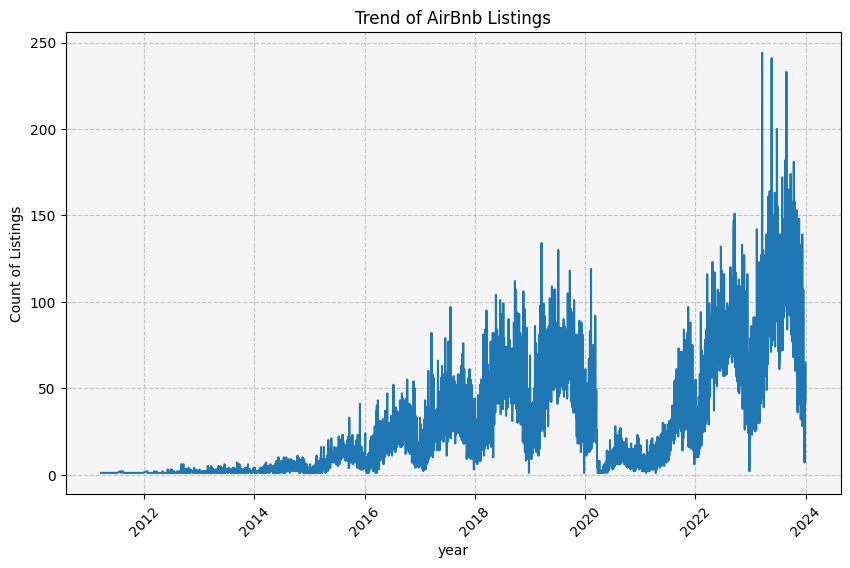

In [185]:
# Count occurrences of each date and sort by index
date_counts = dublin_merged_df['date'].value_counts().sort_index()

# Filter out dates in 2024
date_counts = date_counts[date_counts.index.year < 2024]

# Create line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=date_counts.index, y=date_counts.values)

# Customize the plot background
plt.gca().set_facecolor('#f5f5f5')  # Light grey background
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('year')
plt.ylabel('Count of Listings')
plt.title('Trend of AirBnb Listings')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

From the chart above, we can clearly see that Airbnb listings in Dublin has seen an increase over the years.

**Host First reviews**

In [186]:
# Convert host_since to datetime
dublin_merged_df['host_since'] = pd.to_datetime(dublin_merged_df['host_since'], errors='coerce')

dublin_merged_df['host_since'] = pd.to_datetime(dublin_merged_df['host_since'])
dublin_merged_df['first_review'] = pd.to_datetime(dublin_merged_df['first_review'])

In [187]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(dublin_merged_df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(dublin_merged_df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 25 November 2009, and the most recent joined on 30 April 2025.


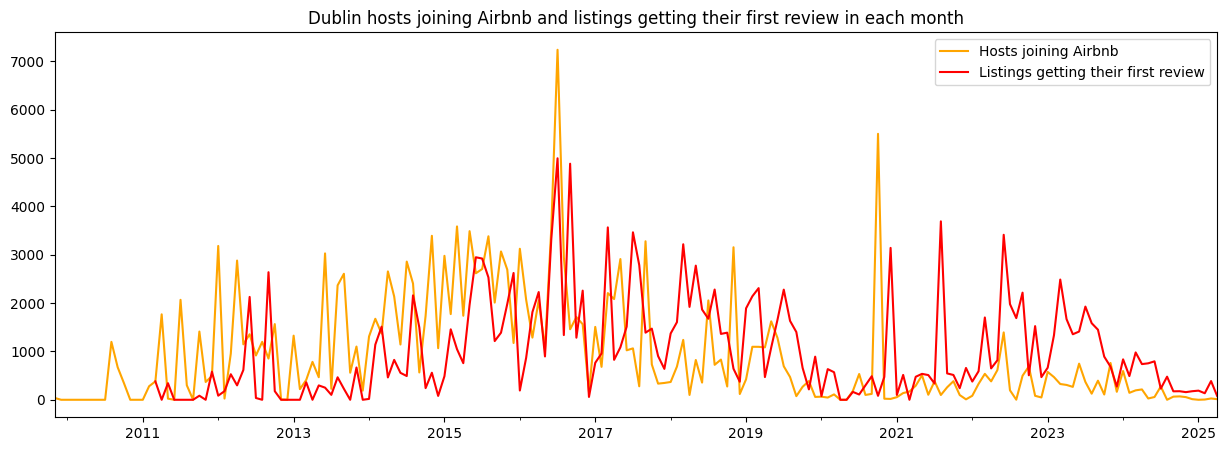

In [188]:
plt.figure(figsize=(15,5))
dublin_merged_df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
dublin_merged_df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')
plt.title('Dublin hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2009-11-25', '2025-04-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

**Host joining Airbnb each month**

In [189]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(dublin_merged_df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(dublin_merged_df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [190]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_time_series(dublin_merged_df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(dublin_merged_df)

    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(dublin_merged_df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

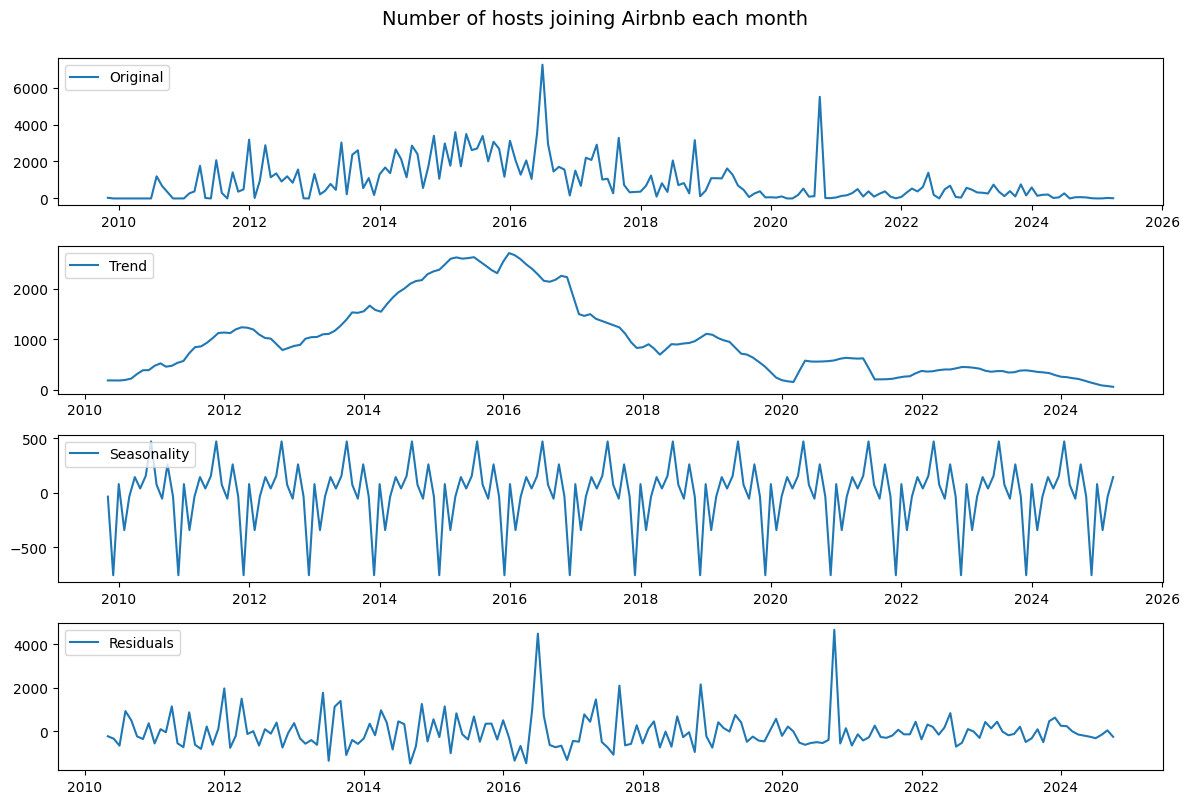

In [191]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

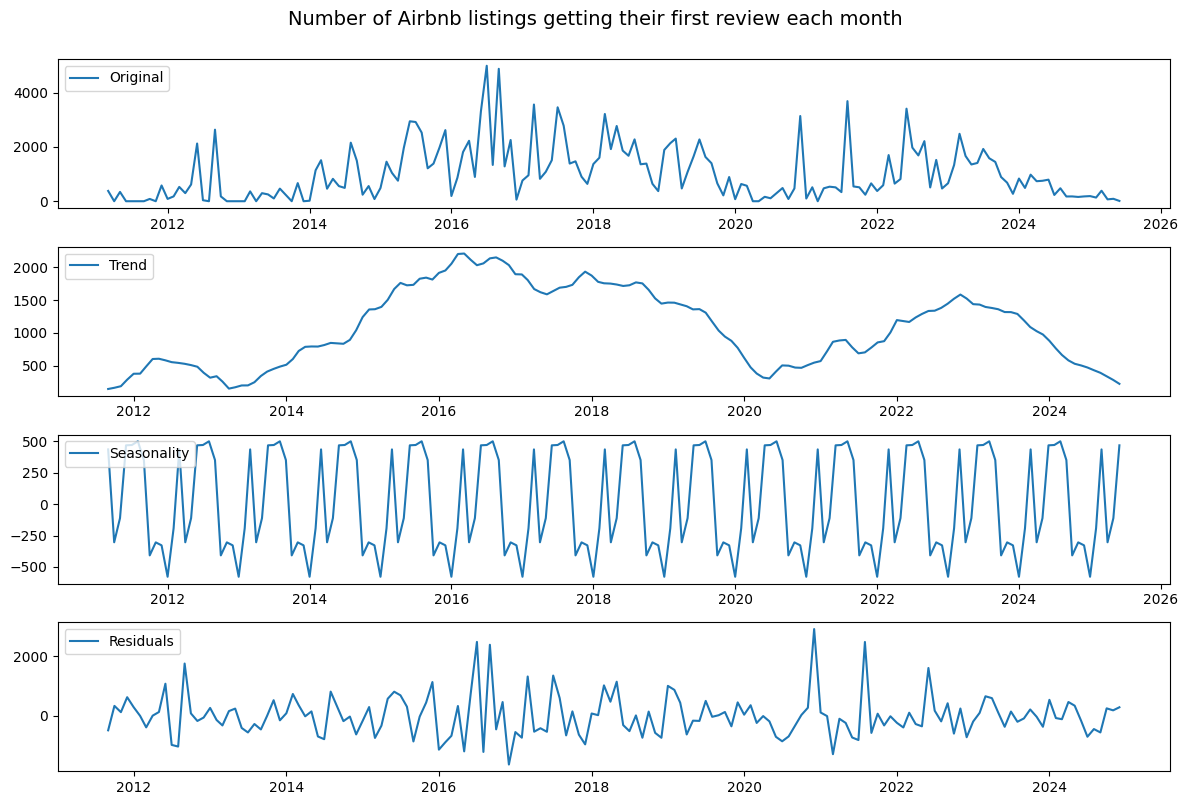

In [192]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

**Host response time**

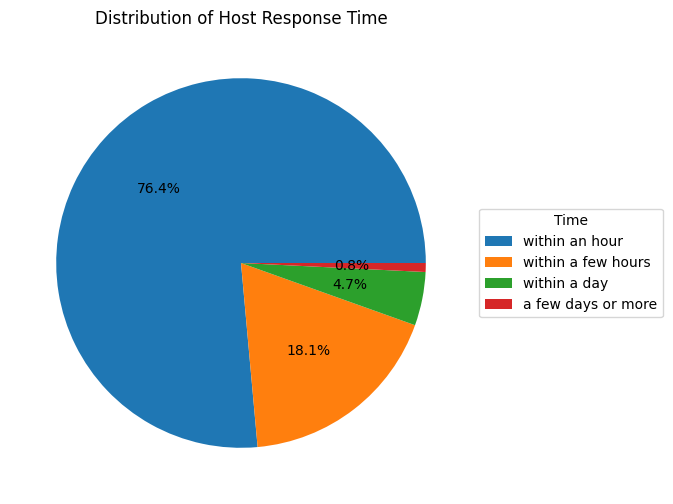

In [193]:
plt.figure(figsize=(10,6))
plt.pie(dublin_merged_df.host_response_time.value_counts(), autopct='%1.1f%%')
plt.title('Distribution of Host Response Time')
plt.legend(labels = dublin_merged_df.host_response_time.value_counts().index, title="Time", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

From the pie chart above, we can see that most host responds to request quickly with a vast majority of 76.4% responding within an hour, we can also see that 18.1% of host responds within few hours and finally we can see that only 0.8% responds in days, these people might be very new hosts or host that are not so active on the platform. This can be a key selling point for customers who would love quick response and prompt communication from host

**Superhost Distribution**

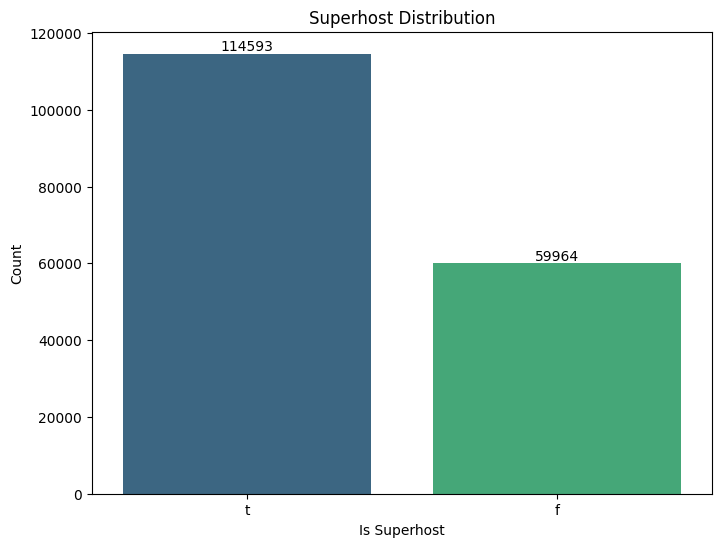

In [194]:
# Create the barplot
plt.figure(figsize=(8,6))

x = dublin_merged_df.host_is_superhost.value_counts().index
y = dublin_merged_df.host_is_superhost.value_counts().values

sns.barplot(x=x, y=y, palette='viridis')

# Add values on top of the bars
for i in range(len(x)):
    plt.text(i, y[i] + 50, str(y[i]), ha='center', va='bottom')

# Add title and labels
plt.title('Superhost Distribution')
plt.ylabel('Count')
plt.xlabel('Is Superhost')

# Display the plot
plt.show()

The bar chart shows that most of the host are superhosts with a staggering 114593

**Host ID Verification**

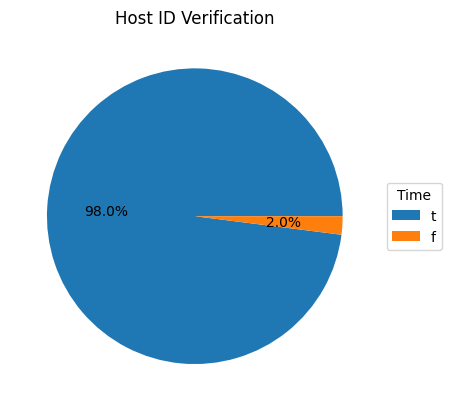

In [195]:
plt.pie(dublin_merged_df.host_identity_verified.value_counts(), autopct='%1.1f%%')
plt.title('Host ID Verification')
plt.legend(labels = dublin_merged_df.host_identity_verified.value_counts().index, title="Time", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

The pie chart above shows that 98.0% of AirBnb hosts are verified hence can be trusted.

**Neighbourhood**

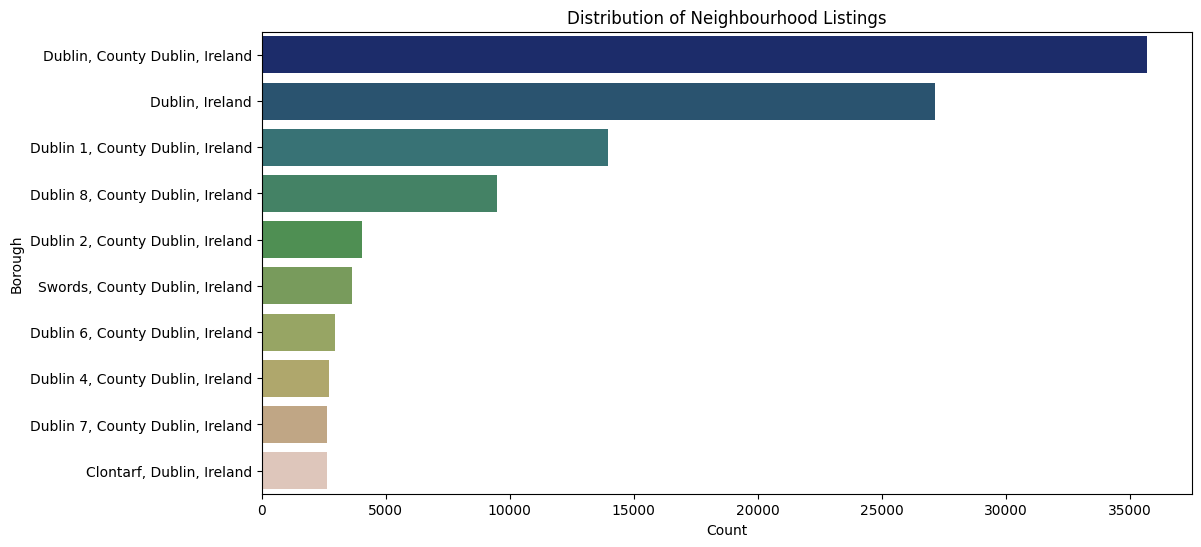

In [196]:
plt.figure(figsize=(12,6))
sns.barplot(x=dublin_merged_df.neighbourhood.value_counts().values[:10], y=dublin_merged_df.neighbourhood.value_counts().index[:10], palette="gist_earth")
plt.title('Distribution of Neighbourhood Listings')
plt.ylabel('Borough')
plt.xlabel('Count')
plt.show()

We can see that Dublin City has the most listings in all the words followed by Fingal, but the gap is so much.

**Area Visualization Heatmap**

In [58]:
# use MarkerCluster
import folium
from folium.plugins import MarkerCluster

# Create map
map_center = [-6.266155, 53.350140]
m = folium.Map(location=map_center, zoom_start=12)

# Create a marker cluster layer
marker_cluster = MarkerCluster().add_to(m)

# Add points to the cluster layer
for idx, row in dublin_merged_df.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=row['name']
    ).add_to(marker_cluster)

# Display map

In [59]:
from folium.plugins import HeatMap

# Create list of points
points = dublin_merged_df[['latitude', 'longitude']].values.tolist()

# Add heatmap layer
HeatMap(points).add_to(m)
display(m)

Output hidden; open in https://colab.research.google.com to view.

In [60]:
# Save the map
m.save('my_heatmap.html')

- The heatmap above shows that the highest concentration (86071 listings) appears to be in the central Dublin City area.

- Airbnbs are heavily concentrated in the tourist-friendly coastal areas and city center, with significantly less activity in the inland regions.

**Property Type**

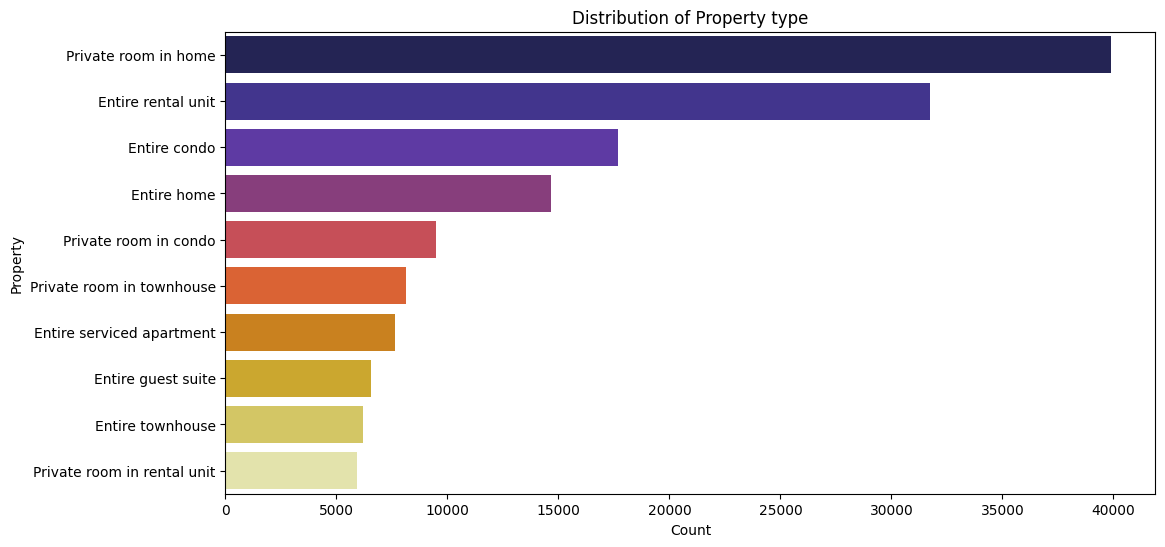

In [197]:
plt.figure(figsize=(12,6))
sns.barplot(x=dublin_merged_df.property_type.value_counts().values[:10], y=dublin_merged_df.property_type.value_counts().index[:10], palette="CMRmap")
plt.title('Distribution of Property type')
plt.ylabel('Property')
plt.xlabel('Count')
plt.show()

- This bar chart shows the distribution of property types. The most common is "Private room in home", followed by "Entire rental unit", while types like "Private room in rental unit" and "Entire townhouse" are the least common. Overall, private rooms and entire units dominate the listings.

**Instant Bookable Distribution**

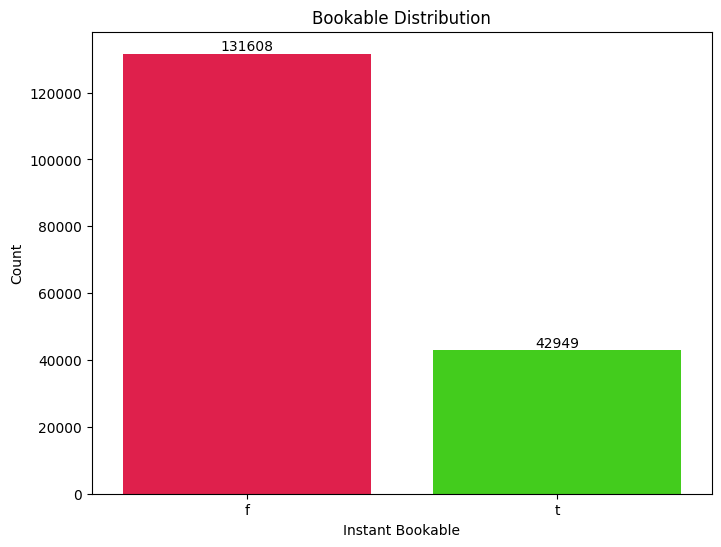

In [198]:
# Create the barplot
plt.figure(figsize=(8,6))

x = dublin_merged_df.instant_bookable.value_counts().index
y = dublin_merged_df.instant_bookable.value_counts().values

sns.barplot(x=x, y=y, palette='prism_r')

# Add values on top of the bars
for i in range(len(x)):
    plt.text(i, y[i] + 50, str(y[i]), ha='center', va='bottom')

# Add title and labels
plt.title('Bookable Distribution')
plt.ylabel('Count')
plt.xlabel('Instant Bookable')

# Display the plot
plt.show()

- The chart shows that most listings (131,608) are not instantly bookable (f), while a smaller portion (42,949) are instantly bookable (t). Instant booking is less common overall.

**Price Distribution**

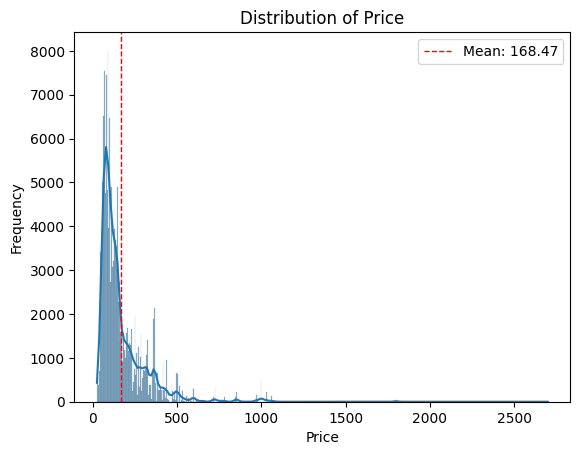

In [199]:
# mean of the 'price' column
mean_value = dublin_merged_df['price'].mean()

# histogram
sns.histplot(dublin_merged_df['price'], kde=True)

# Add a vertical line at the mean
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f}')

# Add legend and labels
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')

plt.show();

The price distribution is right-skewed, with most listings priced below £200. The average price is £168.47, but higher-priced outliers pull the mean to the right.

**Review Comments Analysis**

To better understand the sentiments provided in the reviews dataset we'll use the vadersentiment analyzer to pick up on sentiments in form of compound scores. This feature, named compound_scores, quantifies the overall sentiment polarity of each comment, providing a numeric representation of sentiment strength and orientation (positive, negative, or neutral). The sentiment scores were derived using the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool, which is particularly effective for analyzing social media text and short informal text inputs. VADER returns four sentiment metrics for a given piece of text: positive, negative, neutral, and compound. The compound score is a normalized, weighted composite score that summarizes the overall sentiment of the text on a continuous scale from -1 (most negative) to +1 (most positive).

In [200]:
# initialize vader Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

**Feature engineer to include new column**

In [201]:
# feature engineer and introduce a new column sentiment score
dublin_merged_df['compound_scores'] = dublin_merged_df['comments'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
dublin_merged_df.head(2)

,id_x,listing_url,name,description,neighborhood_overview,picture_url,host_id,host_since,host_response_time,host_response_rate,...,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,instant_bookable,date,reviewer_id,comments,avg_rating,compound_scores
0,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,2010-08-06,within a few hours,100%,...,234,17784.0,2011-03-20,2025-06-01,f,2011-03-20,393348,We enjoyed our stay very much. The room was co...,4.827143,0.9849
1,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,2010-08-06,within a few hours,100%,...,234,17784.0,2011-03-20,2025-06-01,f,2011-03-28,444004,We have been here 4 nights. Stay in a home is ...,4.827143,0.9846


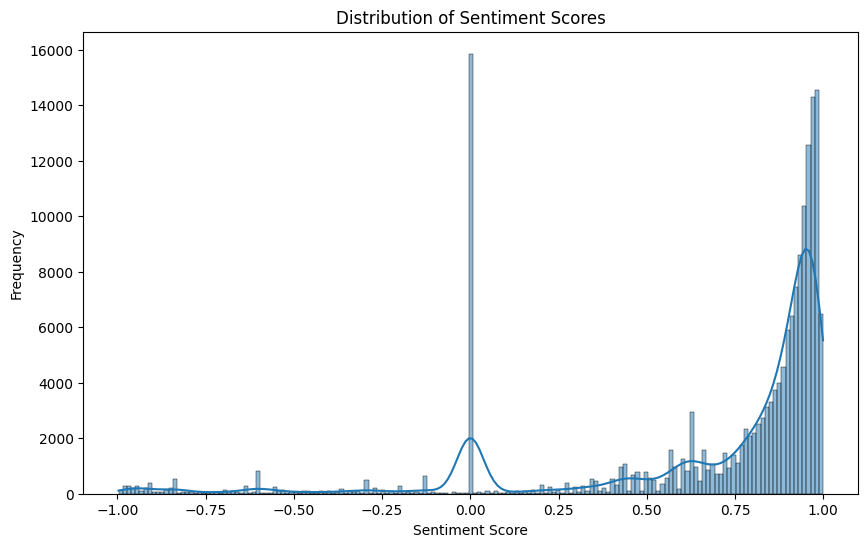

In [202]:
# check the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(dublin_merged_df['compound_scores'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

- Negative Scores (-1 to 0): Shows negative sentiment.
- Positive Scores (0 to +1): Show positive sentiment.
- Neutral Score (0): neutral, with no strong emotion.

The sentiment score distribution is skewed strongly positive, with a large spike near 1.0, indicating most reviews are highly positive. There's also a notable peak at 0, suggesting some neutral or ambiguous reviews. Negative sentiments are relatively rare.

- This indicates that most comments express positive sentiments.
- A noticeable spike around the 0 score suggests that many comments are neutral or lack strong sentiment.
- Negative sentiment scores appear far less frequent, indicating relatively few strongly negative comments.

## Bivariate Analysis

**Monthly trend in price**

Next, we'll create a line chart to show trends over time. We'll group the data by month. first, let's extract the month from the date column.

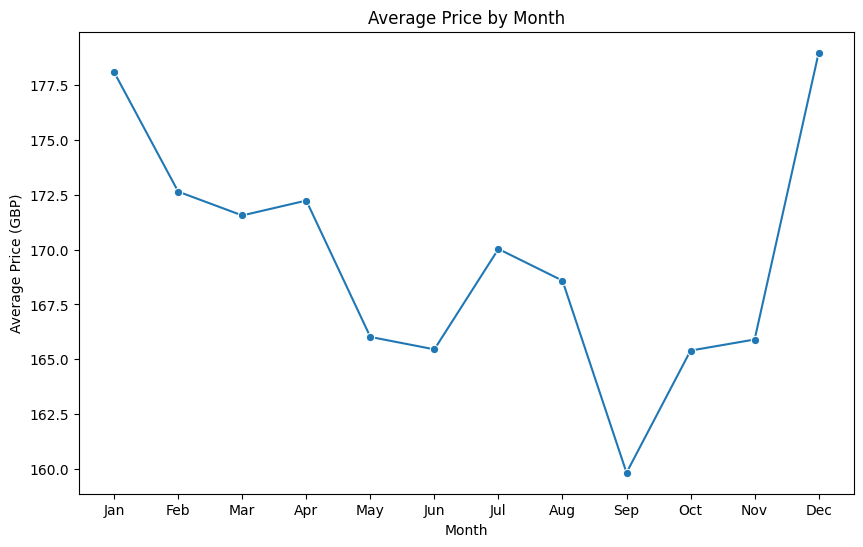

In [203]:
# month
dublin_merged_df['month'] = dublin_merged_df['date'].dt.month

# Calculate average price per month
avg_price_per_month = dublin_merged_df.groupby('month')['price'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(10,6))
sns.lineplot(x='month', y='price', data=avg_price_per_month, marker='o')

# labels and title
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price (GBP)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# Show the plot
plt.show();

Alot can be seen in this trend. As it clearly shows that there's Airbnb listings boom during the holiday periods and we can see from the chart that theres a spike both in January and December and lowest in September.

**Average Price by Season**

Now, we'll analyze seasonal variations in prices. First, we'll create a season column based on the listing dates, then use a bar plot to visualize the average price for each season. We'll categorize each month into a season (winter, spring, summer, autumn). We use the Northern Hemisphere, because Dublin falls under that Hemisphere so it follows the standard meteorological seasons, which are:
- Winter: December, January, February.
- Spring: March, April, May.
- Summer: June, July, August.
- Autumn: 	September, October, November.

In [204]:
# Ensuring date column is in datetime format
dublin_merged_df['date'] = pd.to_datetime(dublin_merged_df['date'])

# function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'

# Apply the function to create a 'season' column
dublin_merged_df['season'] = dublin_merged_df['date'].dt.month.apply(get_season)

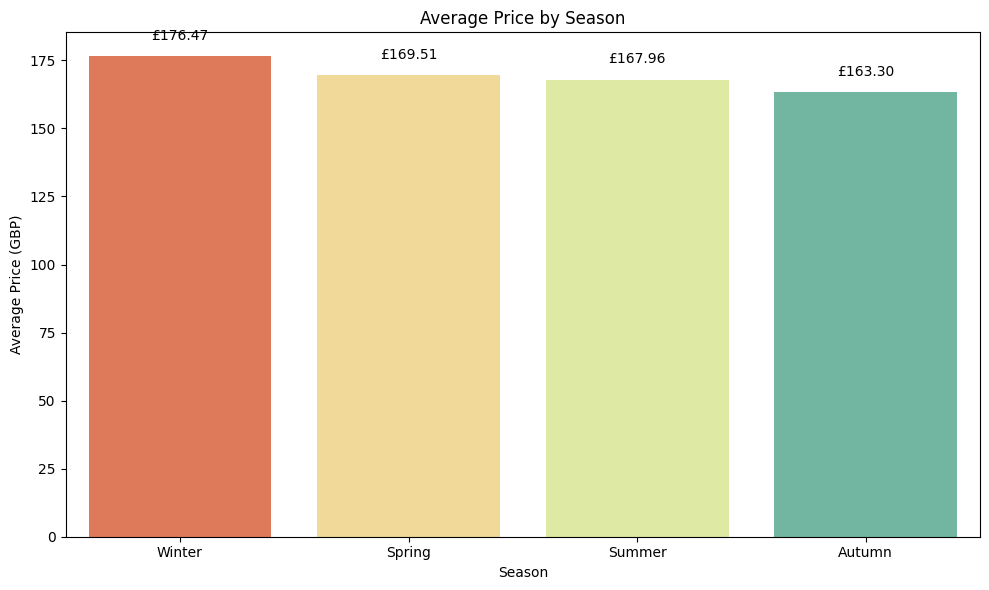

In [205]:
# Ensure 'season' is a category with proper order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
dublin_merged_df['season'] = pd.Categorical(dublin_merged_df['season'], categories=season_order, ordered=True)

# Calculate average price per season
avg_price_per_season = (
    dublin_merged_df
    .groupby('season')['price']
    .mean()
    .reset_index()
    .sort_values(by='price')
)

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='season', y='price', data=avg_price_per_season, palette='Spectral')

# Add labels on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        f"£{height:.2f}",
        ha='center',
        va='bottom',
        color='black'
    )

# Add labels and title
ax.set_title('Average Price by Season')
ax.set_xlabel('Season')
ax.set_ylabel('Average Price (GBP)')

plt.tight_layout()
plt.show()


This chart shows the average rental price by season in Dublin:

1. Winter (£176.47) has the highest average price.

2. Autumn (£163.30) has the lowest average price.

3. Summer (£169.51) and Spring (£167.96) are in between.

Rental prices tend to peak in winter and dip slightly in autumn, with relatively stable pricing across the other seasons.

**Distribution of Price by Average Rating**

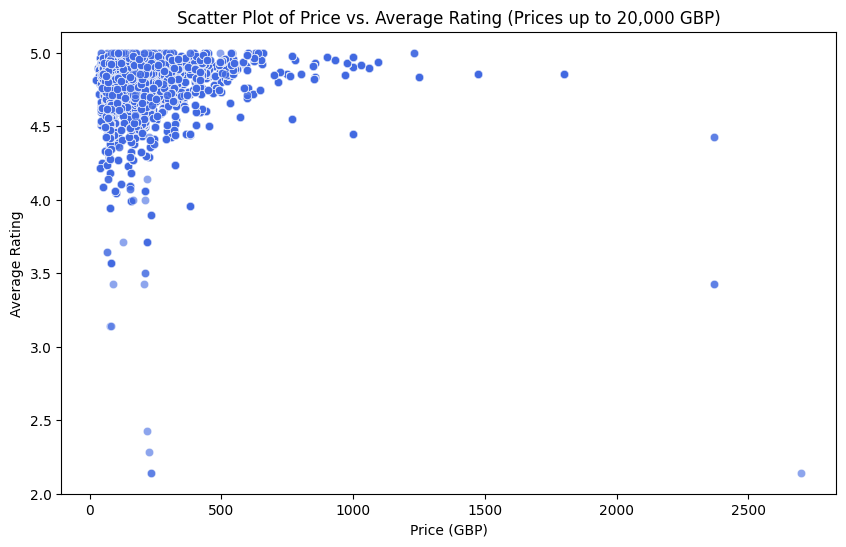

In [206]:
# Create a scatter plot to visualize the relationship between price and avg_rating
# Convert the 'price' column to numeric and remove $ sign
dublin_merged_df['price'] = dublin_merged_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Filter df to include only listings with a price of up to GBP 20,000
filtered_df = dublin_merged_df[dublin_merged_df['price'] <= 20000]

# Create scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot with a soft blue color and transparency for better visual appeal
sns.scatterplot(x='price', y='avg_rating', data=filtered_df, color='royalblue', alpha=0.6)

# labels, title
plt.title('Scatter Plot of Price vs. Average Rating (Prices up to 20,000 GBP)')
plt.xlabel('Price (GBP)')
plt.ylabel('Average Rating')
plt.show()


This scatter plot shows the relationship between the price and the average rating of properties, with prices up to £20,000.

Key observations:

- The majority of properties, regardless of price, have high average ratings, clustering around 4.5 to 5.0.
- Fewer properties have lower average ratings (below 4.0), spread across various price points.
- No clear trend indicates that higher prices correlate with higher average ratings or vice versa.
- There's a dense concentration of items with prices below £500 and ratings between 4.5 and 5.0.
- This scatter plot shows that high ratings are common across a wide range of prices.

Higher price does not guarantee a higher rating. Quality (as perceived by guests) appears largely independent of price, especially at the lower to mid price range.

**Distribution of Price by Property Type**

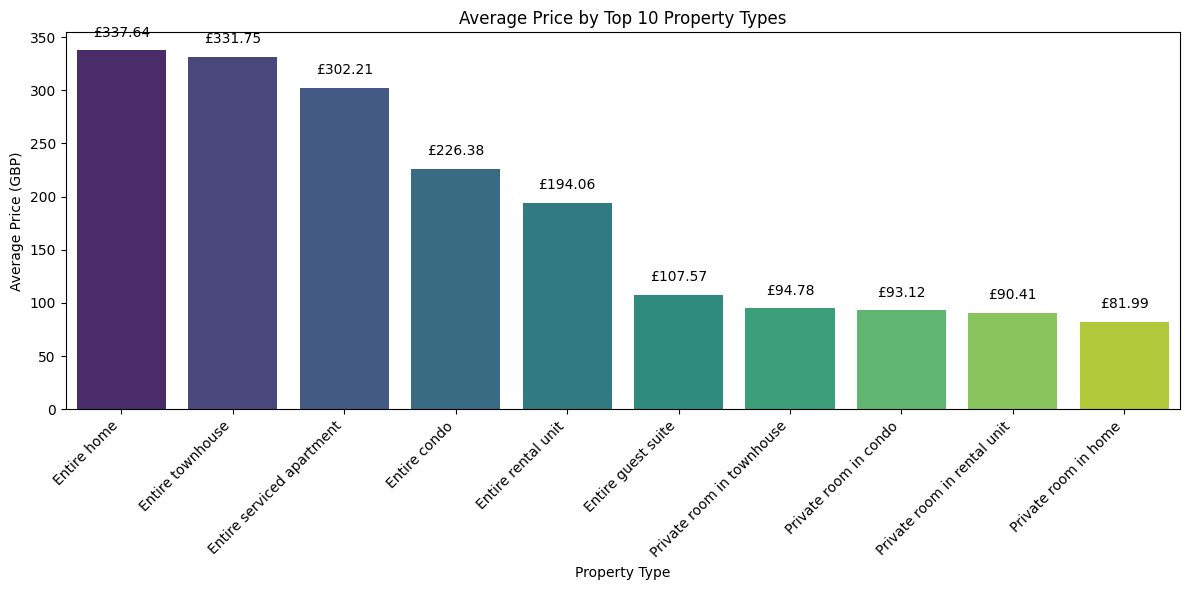

In [207]:
# Count the occurrences of each property type
property_counts = dublin_merged_df['property_type'].value_counts()

# Select the top 10 most common property types
top_property_types = property_counts.nlargest(10).index

# Filter data for top property types and calculate average price
avg_price_per_property_type = (
    dublin_merged_df[dublin_merged_df['property_type'].isin(top_property_types)]
    .groupby('property_type')['price']
    .mean()
    .reset_index()
    .sort_values(by='price', ascending=False)
)

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='property_type',
    y='price',
    data=avg_price_per_property_type,
    palette='viridis'
)

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add price labels on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 10,
        f"£{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Add labels and title
ax.set_title('Average Price by Top 10 Property Types')
ax.set_xlabel('Property Type')
ax.set_ylabel('Average Price (GBP)')

plt.tight_layout()
plt.show()

This bar chart shows the average price of the top 10 property types in Dublin.

- Entire home (£337.64) and Entire townhouse (£331.75) are the most expensive property types.

- Private rooms are consistently the cheapest, with Private room in home being the lowest at £81.99.

- Entire serviced apartment (£302.21) and Entire condo (£226.38) also command high prices.

- There's a clear price gap between entire-unit properties and private/shared spaces.

What this tells us is that offering an entire property significantly increases the listing price compared to renting out individual rooms.

**Average Ratings of Superhosts vs. Non-Superhosts**

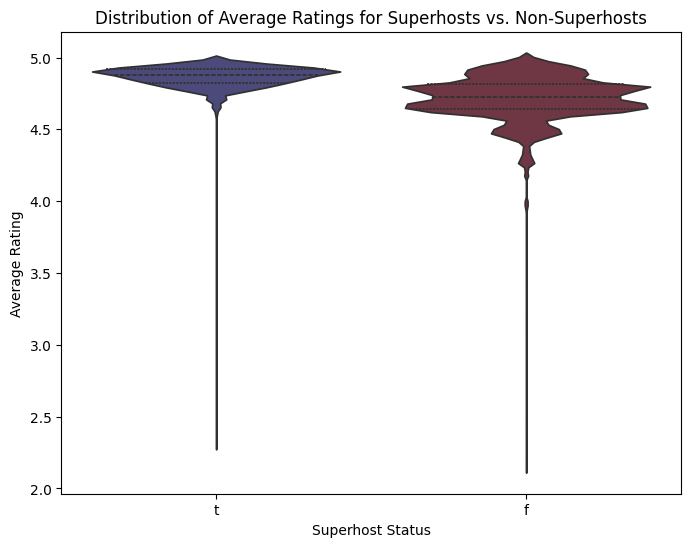

In [208]:
# Violin plot to compare avg_rating between superhosts and non-superhosts
plt.figure(figsize=(8, 6))
sns.violinplot(x='host_is_superhost', y='avg_rating', data=dublin_merged_df, inner='quartile', palette='icefire')

# labels and title
plt.title('Distribution of Average Ratings for Superhosts vs. Non-Superhosts')
plt.xlabel('Superhost Status')
plt.ylabel('Average Rating')
plt.show()

This violin plot compares the distribution of average ratings between superhosts (t) and non-superhosts (f).

Superhosts (t):

- Ratings are tightly concentrated around 4.9 to 5.0, indicating consistently high guest satisfaction.

- The distribution is narrow and sharply peaked, suggesting very little variation in ratings.

Non-superhosts (f):

- Wider spread in ratings, ranging from around 4.0 to 5.0, with some outliers below 4.

- Most common ratings are between 4.6 and 4.8, slightly lower than superhosts.


This tell us that Superhosts generally receive higher and more consistent ratings compared to non-superhosts, highlighting the value of hosting experience and quality service.

**Ratings Distributions Across Property Types**

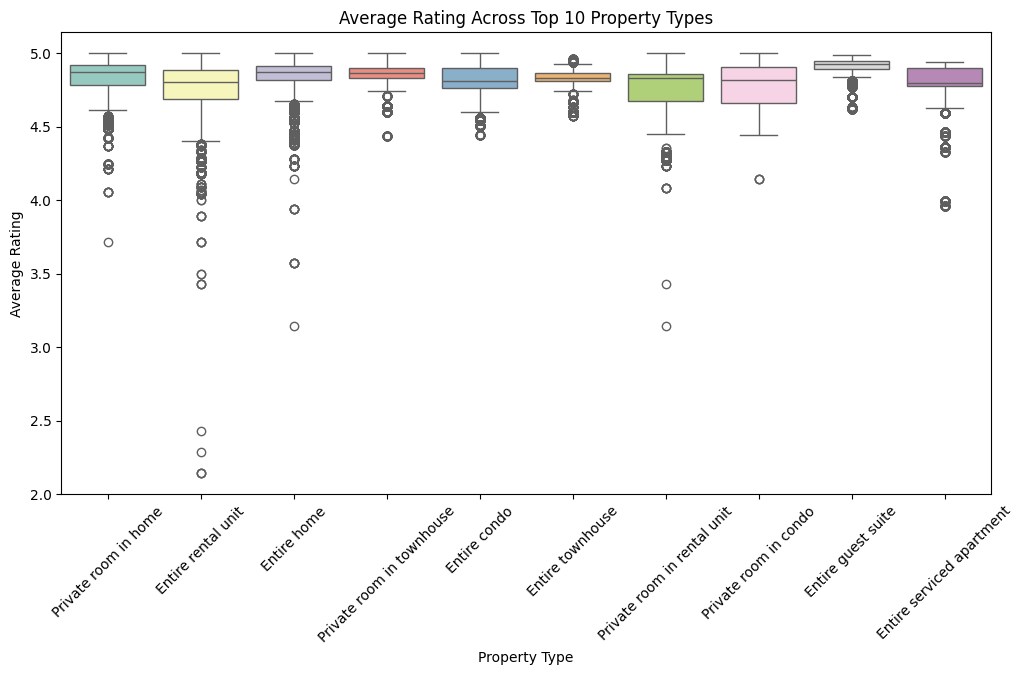

In [209]:
# Count the occurrences of each property type
property_counts = dublin_merged_df['property_type'].value_counts()

# Select the top 10 most common property types
top_property_types = property_counts.nlargest(10).index

# Filter the DataFrame for the top property types
filtered_df = dublin_merged_df[dublin_merged_df['property_type'].isin(top_property_types)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='property_type', y='avg_rating', data=filtered_df, palette='Set3')

# Add labels and title
plt.title('Average Rating Across Top 10 Property Types')
plt.xlabel('Property Type')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

This box plot compares the average ratings across the top 10 property types.

- All property types generally receive high ratings, with medians clustered around 4.8 to 4.9, indicating good overall guest satisfaction.

- "Entire home", "Private room in home", and "Entire guest suite" tend to have slightly higher and more consistent ratings (less variation).

- "Entire rental unit" and "Entire serviced apartment" show more variability and several lower outliers, meaning some listings in these categories may deliver a poorer guest experience.

- Outliers exist across all categories but are more frequent in property types like:

"Entire rental unit"

"Entire serviced apartment"

"Entire townhouse"

While most property types maintain high average ratings, entire homes and private rooms in homes are among the most consistently well-rated, suggesting they may offer a more reliable or familiar guest experience. Properties with wider rating spreads may benefit from quality standardization or host improvements.



In [210]:
# Import necessary library
from wordcloud import WordCloud

# Define stopwords
stopwords_n = set(["the", "in", "and", "of", "to", "a", "is", "Dublin City", "with", "Dublin", "City"])

def generate_wordcloud(df, stopwords, max_words, colormap, bg_color="black"):
    text = " ".join(str(name).lower() for name in df['name'].dropna())
    if not text.strip():  # Check if text is empty after stripping whitespace
        print("⚠️ No words found for this price range.")
        return None
    return WordCloud(
        max_font_size=500,
        background_color=bg_color,
        width=1600,
        height=800,
        collocations=True,
        stopwords=stopwords,
        max_words=max_words,
        colormap=colormap
    ).generate(text)

# High price listings
high = dublin_merged_df[dublin_merged_df['price'] >= 2000]
high_wc = generate_wordcloud(high, stopwords_n, max_words=50, colormap='spring')

# Low price listings
low = dublin_merged_df[dublin_merged_df['price'] <= 1000]
low_wc = generate_wordcloud(low, stopwords_n, max_words=50, colormap='Pastel1')

# Intermediate price listings
inter = dublin_merged_df[(dublin_merged_df['price'] > 1000) & (dublin_merged_df['price'] < 10000)]
int_wc = generate_wordcloud(inter, stopwords_n, max_words=50, colormap='winter')

# All price categories
all_wc = WordCloud(
    max_font_size=500,
    background_color="white",
    width=1600,
    height=800,
    collocations=False,
    stopwords=stopwords_n,
    max_words=75,
    colormap='icefire_r'
).generate(" ".join(str(name).lower() for name in dublin_merged_df['name'].dropna()))

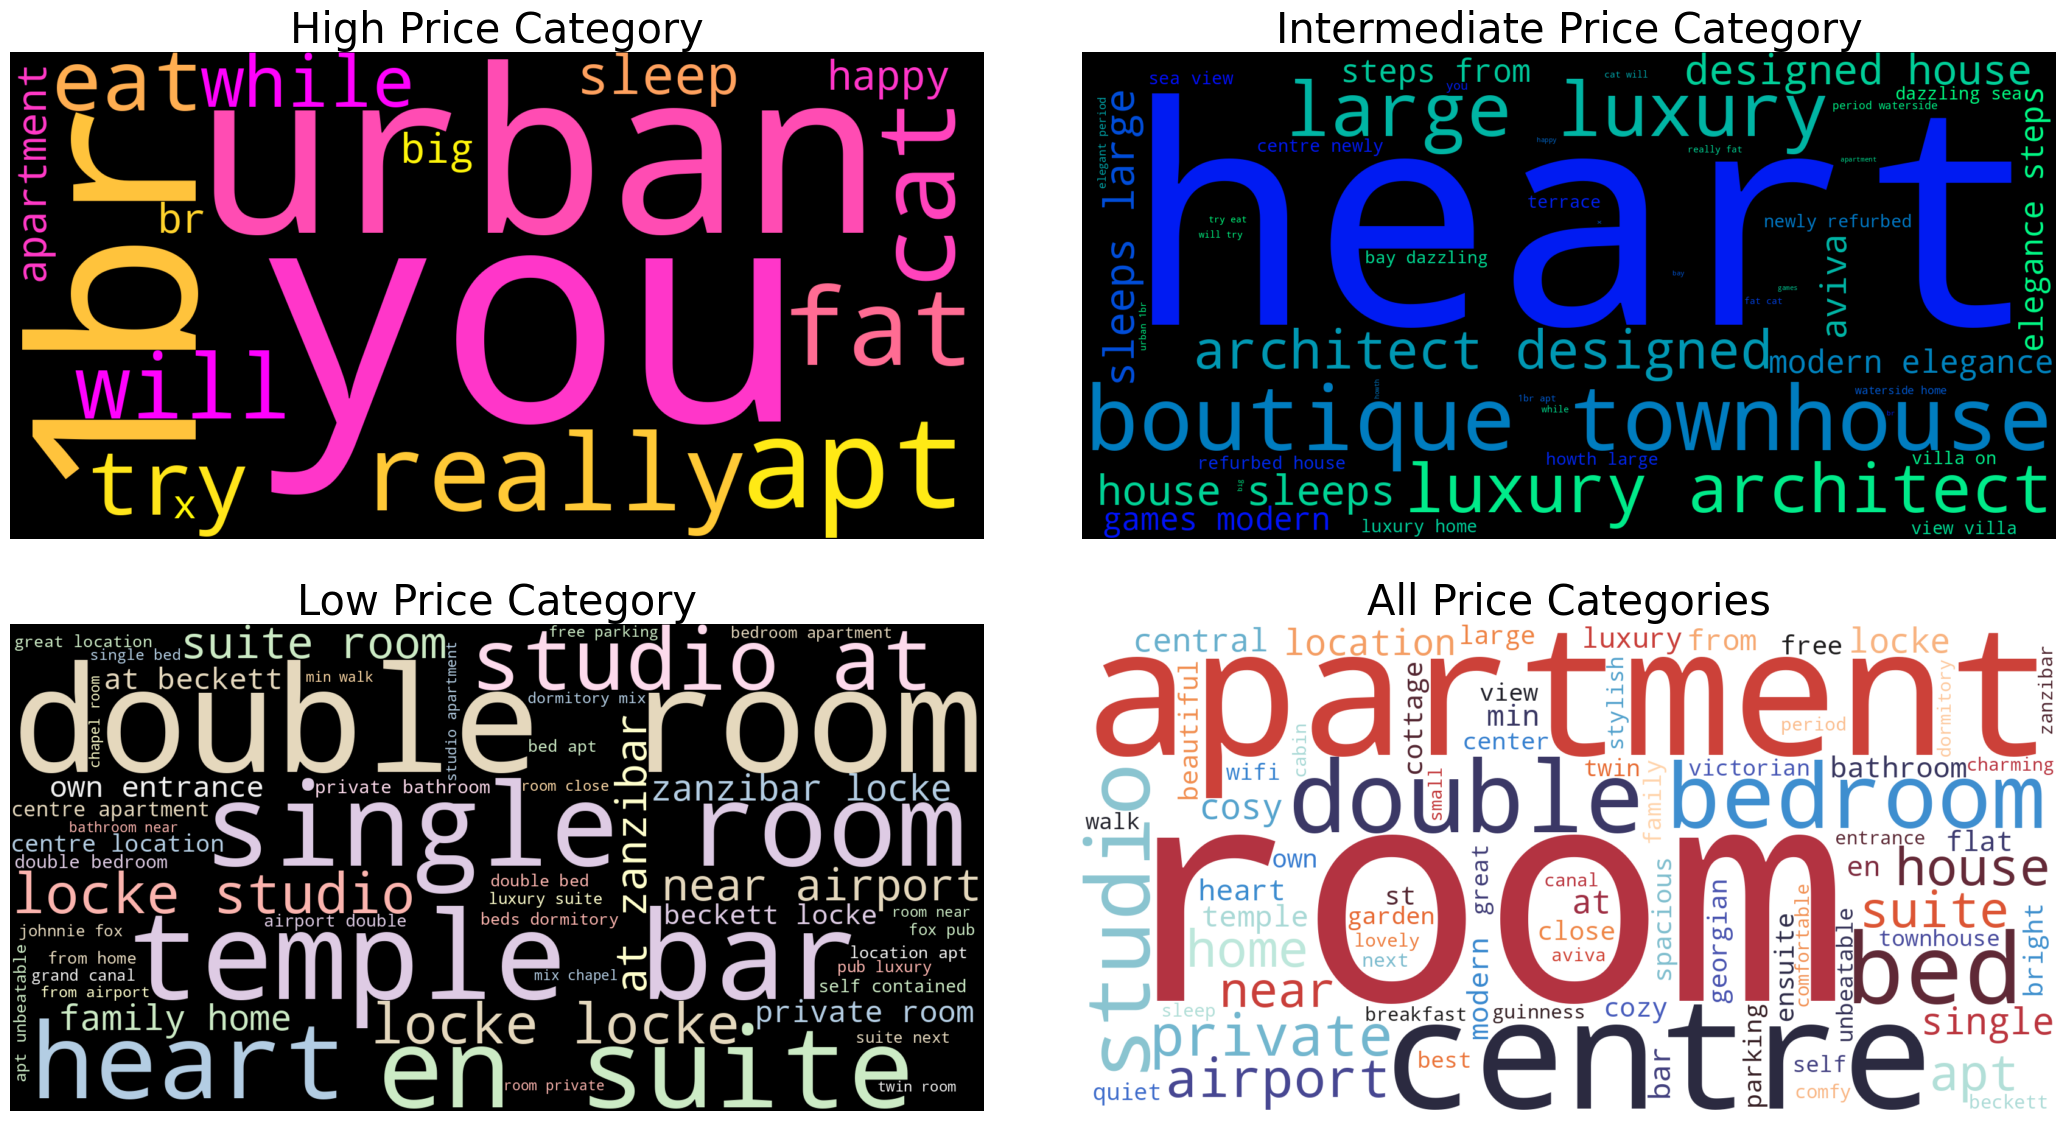

In [211]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(22, 12))
fig.tight_layout(pad=4)  # Slight padding for spacing

# Plot High Price Word Cloud
if high_wc:
    axs[0, 0].imshow(high_wc, interpolation='bilinear')
    axs[0, 0].set_title('High Price Category', fontsize=30)
else:
    axs[0, 0].text(0.5, 0.5, 'No Data', fontsize=25, ha='center', va='center')
    axs[0, 0].set_title('High Price Category', fontsize=30)
axs[0, 0].axis('off')

# Plot Intermediate Price Word Cloud
if int_wc:
    axs[0, 1].imshow(int_wc, interpolation='bilinear')
    axs[0, 1].set_title('Intermediate Price Category', fontsize=30)
else:
    axs[0, 1].text(0.5, 0.5, 'No Data', fontsize=25, ha='center', va='center')
    axs[0, 1].set_title('Intermediate Price Category', fontsize=30)
axs[0, 1].axis('off')

# Plot Low Price Word Cloud
if low_wc:
    axs[1, 0].imshow(low_wc, interpolation='bilinear')
    axs[1, 0].set_title('Low Price Category', fontsize=30)
else:
    axs[1, 0].text(0.5, 0.5, 'No Data', fontsize=25, ha='center', va='center')
    axs[1, 0].set_title('Low Price Category', fontsize=30)
axs[1, 0].axis('off')

# Plot All Prices Word Cloud
if all_wc:
    axs[1, 1].imshow(all_wc, interpolation='bilinear')
    axs[1, 1].set_title('All Price Categories', fontsize=30)
else:
    axs[1, 1].text(0.5, 0.5, 'No Data', fontsize=25, ha='center', va='center')
    axs[1, 1].set_title('All Price Categories', fontsize=30)
axs[1, 1].axis('off')

# Show the full plot
plt.show()


Drop host_since, first_review and last_review columns as we do not need them anymore

In [212]:
cols_to_drop = ['host_since', 'first_review', 'last_review']
dublin_merged_df = dublin_merged_df.drop(columns=[col for col in cols_to_drop if col in dublin_merged_df.columns])

# Multivariate Analysis
**Correlation Matrix**

The heatmap will help us visualize the correlations between numeric variables in the dataset, highlighting how they relate to each other.

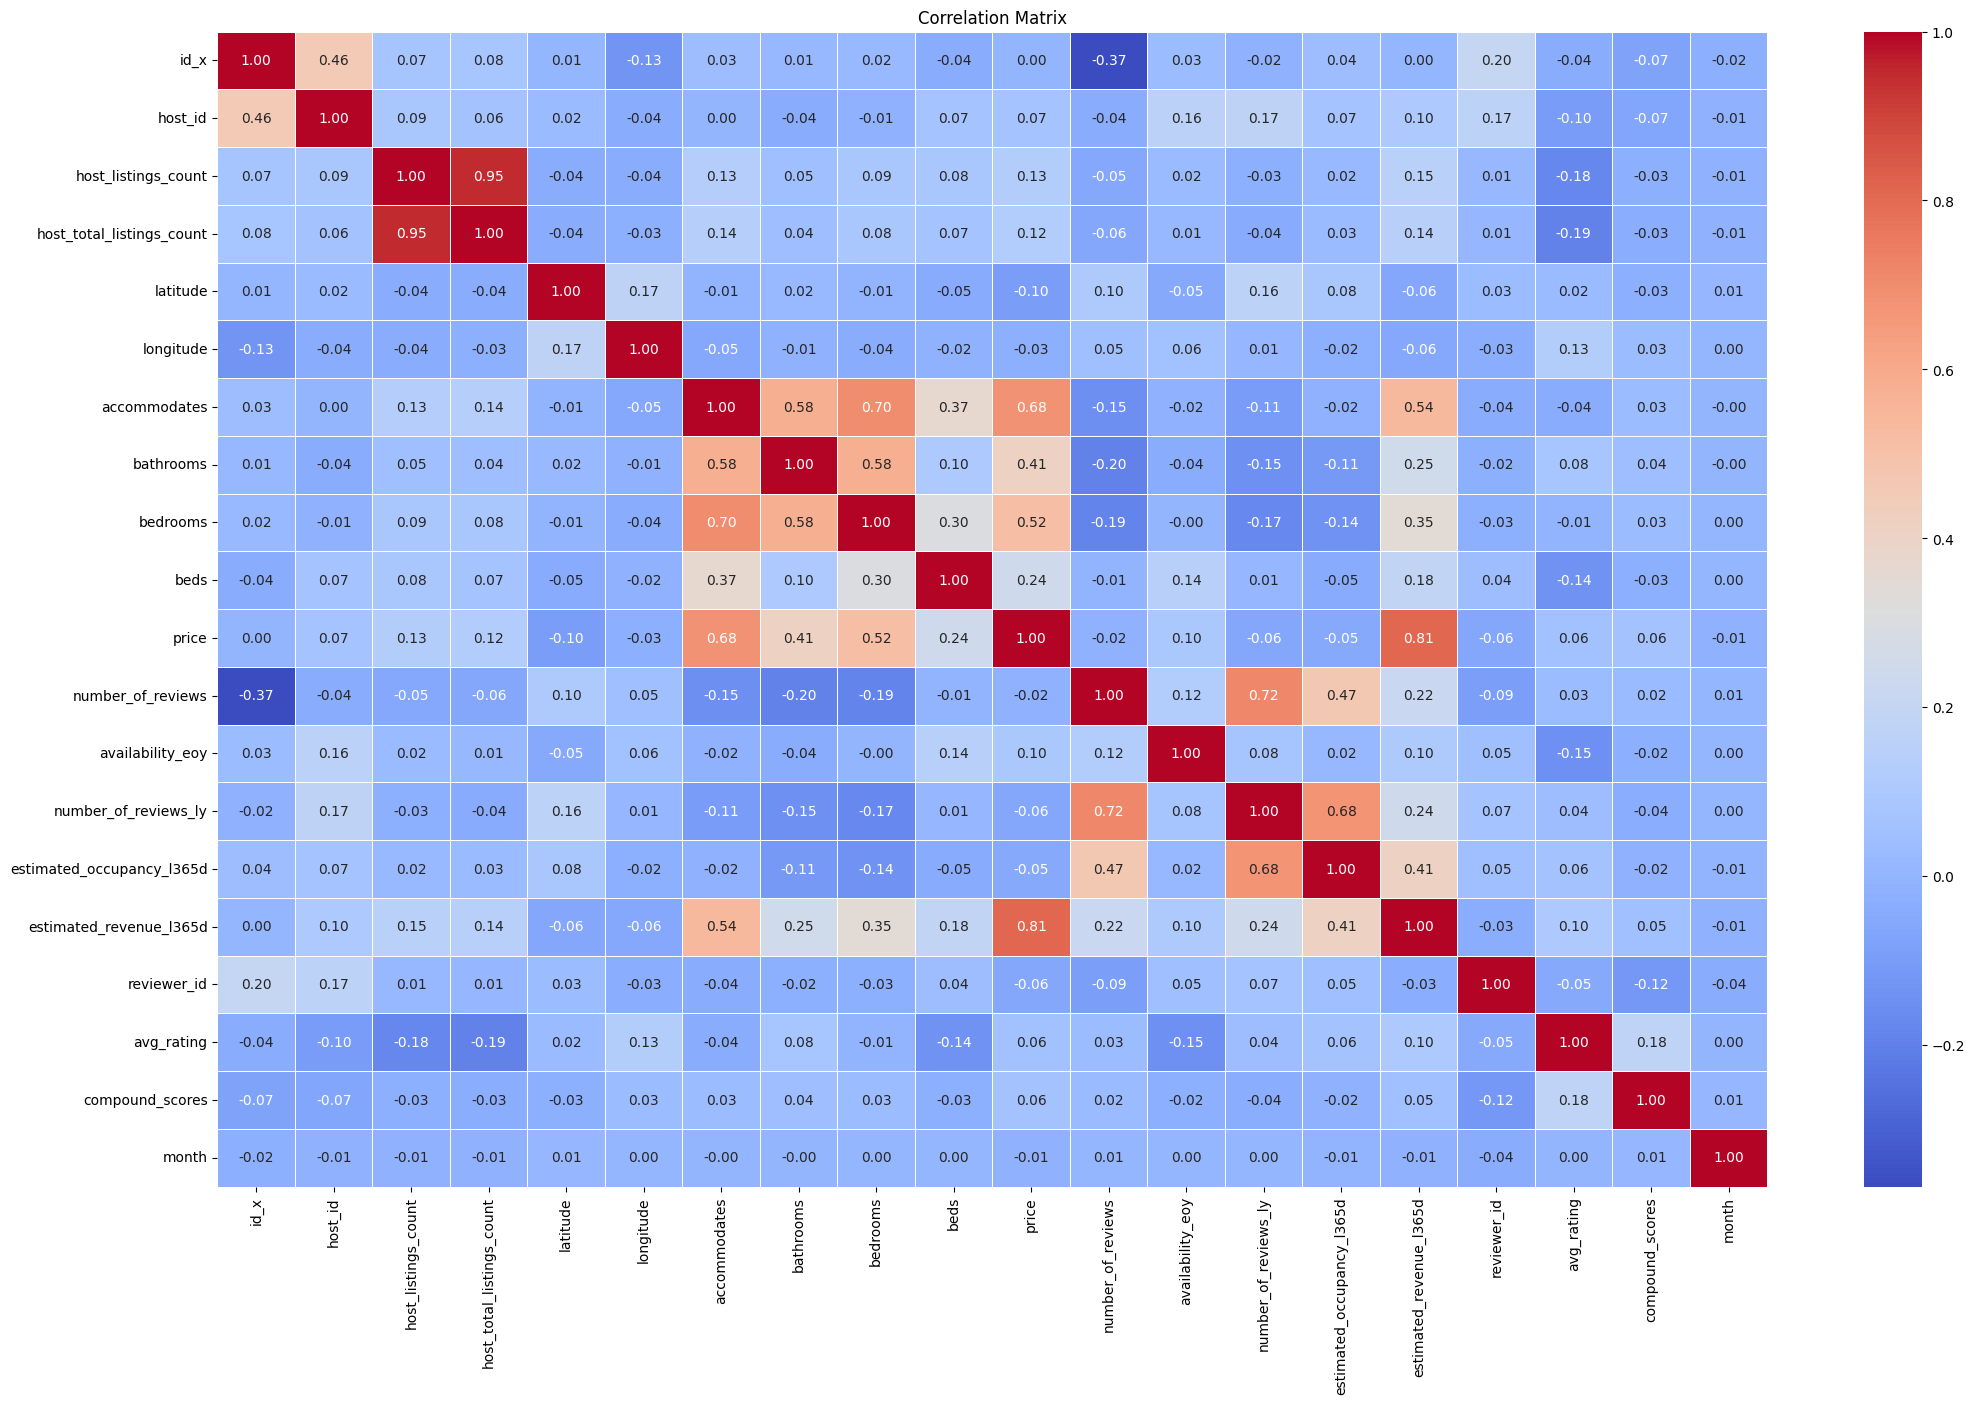

In [213]:
# Filter the dataframe to select only numeric columns
numeric_df = dublin_merged_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

From the correlation metrics, we can see the following strong predictors of price; Accommodates (corr = 0.68), Estimated Revenue (365d) (corr = 0.81) – highly correlated, but could cause leakage if it's derived from price, Bedrooms (0.52), Bathrooms (0.40), Beds (0.24), Number of Reviews (0.20) – moderately helpful, could reflect popularity, Host Total Listings Count (0.17) – may reflect host scale or professionalism

While the following to be cautious with, which are
Estimated revenue, Reviewer ID, Host ID ( identifiers that are not useful)

Latitude/Longitude(This can only be used if converted to neighborhoods, but we are not looking at that in this case)

Ratings (avg_rating, compound_scores) – low correlation; may not help much. We would be including this in our selected features


**Pairplot for Selected Features**

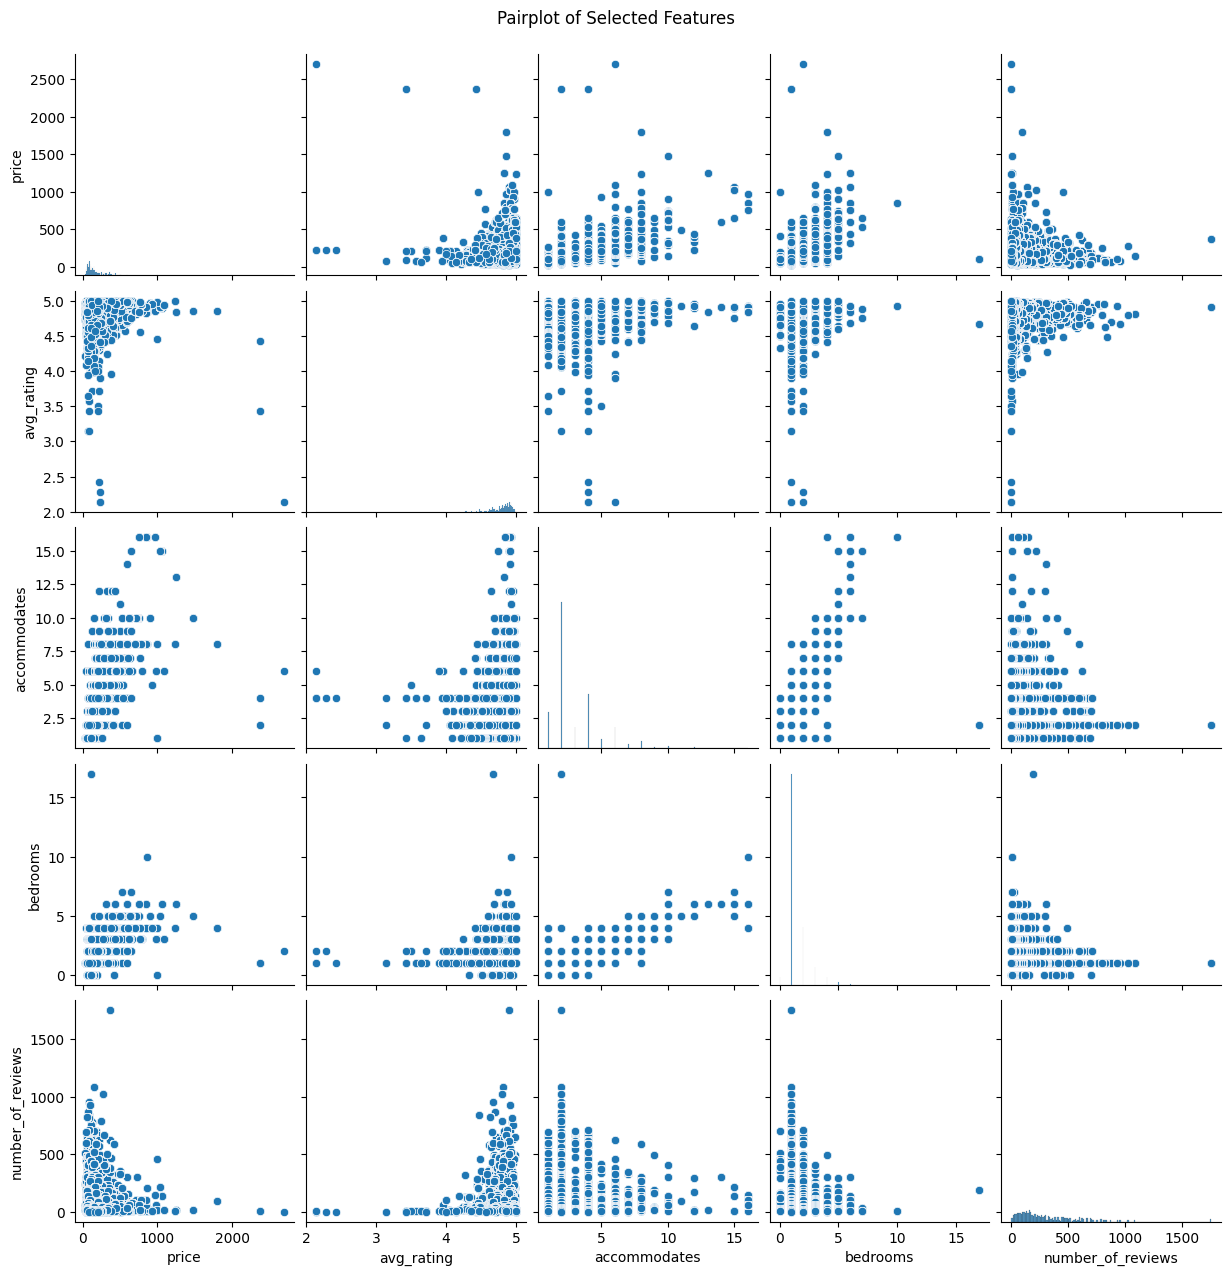

In [214]:
# Selecting a subset of features for pairplot
selected_features = dublin_merged_df[['price', 'avg_rating', 'accommodates', 'bedrooms', 'number_of_reviews']]

# Create pairplot
sns.pairplot(selected_features)
plt.suptitle('Pairplot of Selected Features', y=1.02)  # Adjust the title position
plt.show()

This pairplot shows:

- Price increases with more bedrooms and accommodates.

- Price doesn't correlate clearly with average rating.

- Listings with more reviews tend to have lower prices.

- Most ratings are clustered near 5 stars (very high).

- Accommodates and bedrooms are strongly correlated.

In short: accommodates and bedrooms are good predictors of price; ratings and reviews less so.

## Feature Engineering

**Anova Test**

Now, we will conduct an ANOVA test to analyze how various factors influence the pricing of Airbnb listings, allowing us to identify significant predictors of price.

In [215]:
dublin_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174557 entries, 0 to 310083
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id_x                       174557 non-null  int64         
 1   listing_url                174557 non-null  object        
 2   name                       174557 non-null  object        
 3   description                174557 non-null  object        
 4   neighborhood_overview      174557 non-null  object        
 5   picture_url                174557 non-null  object        
 6   host_id                    174557 non-null  int64         
 7   host_response_time         174557 non-null  object        
 8   host_response_rate         174557 non-null  object        
 9   host_is_superhost          174557 non-null  object        
 10  host_listings_count        174557 non-null  float64       
 11  host_total_listings_count  174557 non-null  float64      

In [217]:
from statsmodels.formula.api import ols
import statsmodels.api as sm


# ANOVA formula
formula = 'price ~ C(host_response_time) + C(host_is_superhost) + C(neighbourhood) + C(property_type) + C(room_type) + accommodates + bathrooms + bedrooms + beds + number_of_reviews + C(instant_bookable) + avg_rating + C(season)'

# Fit the model
model = ols(formula, data=dublin_merged_df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                             sum_sq        df             F         PR(>F)
C(host_response_time)  1.267301e+06       3.0     58.947356   4.432531e-38
C(host_is_superhost)   1.001120e+07       1.0   1396.985540  1.543551e-304
C(neighbourhood)       1.830391e+08     221.0    115.573220   0.000000e+00
C(property_type)       2.015974e+08      39.0    721.316780   0.000000e+00
C(room_type)           2.323302e+06       3.0    108.066254   6.680464e-70
C(instant_bookable)    3.589294e+05       1.0     50.085812   1.477187e-12
C(season)              1.704005e+05       3.0      7.926023   2.781258e-05
accommodates           2.052141e+08       1.0  28636.042220   0.000000e+00
bathrooms              4.476343e+05       1.0     62.463890   2.729463e-15
bedrooms               1.089620e+07       1.0   1520.480803   0.000000e+00
beds                   8.650674e+05       1.0    120.713449   4.509902e-28
number_of_reviews      5.972362e+05       1.0     83.339682   6.980675e-20
avg_rating             1.

Only number_of_reviews has no significant effect on price which means volume of reviews doesn’t determine pricing. While the accommodates, bedrooms, avg_rating, property_type, neighbourhood_cleansed, host_is_superhost, instant_bookable, and others are significant predictors of price
IT is surpricing to see that avg_rating became very influential. While number_of_reviews (F = 0.089, p = 0.765) has No significant effect on price.
The reason why avg_rating turn out showing high influence statistically would be as a sresult of clean bounded values i.e avg_rating is on a scale of 1–5 (often clustered around 4.5–5), making it numerically stable and easy to pick up in a linear model. We can also say Perception of quality for exampole, Higher-rated listings may charge more due to trust and guest satisfaction — even small differences (like 4.7 vs. 4.9) can affect price perception.

**Data Aggregation**

In our merged dataframe, each listing can have multiple reviews, leading to duplicate rows for the same listing. To create our baseline linear regression model, we'll first aggregate the data to ensure each listing appears only once.

In [218]:
# Aggregate data to avoid duplicate rows caused by multiple reviews for the same property
dublin_aggregated_df = (
    dublin_merged_df
    .groupby('id_x')
    .agg({
        'host_id': 'first', # Host-related features are constant per listing, so we take the first occurrence
        'host_response_rate': 'first',
        'host_is_superhost': 'first',
        'host_listings_count': 'first',
        'accommodates': 'mean', # we average numerical features across all property info
        'bathrooms': 'mean',
        'bedrooms': 'mean',
        'beds': 'mean',
        'price': 'first', # is taken as the first occurrence since it is consistent across reviews
        'avg_rating': 'mean', # averaged across all reviews
        'number_of_reviews': 'sum',
        'neighbourhood': 'first',
        'property_type': 'first'
    })
    .reset_index()
)

In [219]:
# Clean 'host_response_rate' by removing '%' and converting to numeric
dublin_aggregated_df['host_response_rate'] = (
    dublin_aggregated_df['host_response_rate']
    .str.rstrip('%')  # Remove '%' symbol
    .astype(float) / 100  # Convert to float and scale to [0, 1]
)

Data Aggregation

The dataset is grouped by the property identifier id_x this is to avoid duplicate rows caused by multiple reviews for the same listing.
For each group, the following features where aggregated as follows;
- *Host-related features* (host_id, host_response_rate, host_is_superhost, host_listings_count) are assumed constant for each listing and thus the first occurrence is taken.
- *Numerical property features* (accommodates, bathrooms, bedrooms, beds) are averaged across all rows to account for possible minor variations.
- *Price* is taken as the first occurrence, assuming it remains consistent for the listing.
- *Average rating* is calculated as the mean of all review ratings.
- Number of reviews is summed to capture the total review count for each listing.
- *Categorical features* (neighbourhood_cleansed, property_type) are taken from the first occurrence.

The  host_response_rate column, which was originally stored as a string percentage was cleaned by removing the percentage symbol (%) whcih was done using .str.rstrip('%'), Converting the result to a floating-point number and then scaling the value to a decimal between 0 and 1 by dividing by 100.

Without aggregation, the model might incorrectly treat each review as an independent data point, leading to Overrepresentation of popular listings meaning Properties with many reviews would have disproportionately more rows, skewing the model, Data leakage meaning Repeated entries of the same property with similar features can cause the model to overfit, Inconsistent feature values meaning that  Some features (like ratings or number of reviews) vary across reviews, so a single-row summary is needed to capture the true property profile.

By aggregating the data, We consolidate all reviews into one representative row per listing, maintaining the unique identifier, compute meaningful summary statistics (e.g., average rating, total number of reviews) that better represent the property’s overall characteristics, ensure that constant features (e.g., host ID, neighborhood) remain consistent for each listing and ensure our results in a clean, unbiased, and stable dataset that improves the reliability and accuracy of the predictive model.
## Preprocessing

In [220]:
# Counts of each unique neighbourhood
print(dublin_merged_df['neighbourhood'].value_counts())

# Counts of each unique property type
print(dublin_merged_df['property_type'].value_counts())


neighbourhood
Dublin, County Dublin, Ireland             35707
Dublin, Ireland                            27145
Dublin 1, County Dublin, Ireland           13974
Dublin 8, County Dublin, Ireland            9482
Dublin 2, County Dublin, Ireland            4042
                                           ...  
Druid Valley, County Dublin, Ireland           4
Kingswood Cross, County Dublin, Ireland        4
Cruagh Manor, County Dublin, Ireland           4
County Meath, Ireland                          3
North Wall, County Dublin, Ireland             2
Name: count, Length: 222, dtype: int64
property_type
Private room in home                  39898
Entire rental unit                    31723
Entire condo                          17684
Entire home                           14671
Private room in condo                  9493
Private room in townhouse              8148
Entire serviced apartment              7628
Entire guest suite                     6552
Entire townhouse                       620

In [221]:
print("Unique neighbourhoods:", dublin_merged_df['neighbourhood'].nunique())
print("Unique property types:", dublin_merged_df['property_type'].nunique())


Unique neighbourhoods: 222
Unique property types: 40


In [222]:
# Frequency Encoding for 'neighbourhood' and 'property_type'
# Each had 222 and 40 unique values respectively, therefore couldn't use one-hot encoding
for col in ['neighbourhood', 'property_type']:
    freq_encoding = dublin_aggregated_df[col].value_counts(normalize=True)
    dublin_aggregated_df[f'{col}_freq'] = dublin_aggregated_df[col].map(freq_encoding)

The code iterates over the two categorical columns 'neighbourhood' and 'property_type' and we calculate frequency encoding such that For each column, value_counts(normalize=True) computes the relative frequency (proportion) of each unique category within that column. For example, if 'Dublin City' appears in 30% of listings, its frequency becomes 0.3 and then finally map the frequencies back to the dataframe by using .map(freq_encoding), the code creates a new column named '{col}_freq' (e.g., 'neighbourhood_cleansed_freq') that replaces each category with its corresponding frequency value.

In [223]:
# Encode 'host_is_superhost' as binary (0 and 1)
dublin_aggregated_df['host_is_superhost'] = dublin_aggregated_df['host_is_superhost'].map({'t': 1, 'f': 0})

In [224]:
# Drop original 'neighbourhood' and 'property_type' columns,
# because frequency-encoded columns are now included
dublin_encoded_df = dublin_aggregated_df.drop(['neighbourhood', 'property_type'], axis=1)

In [160]:
dublin_encoded_df.head()

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood_freq,property_type_freq
0,44077,193005,1.00,t,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,0.001211,0.006663
1,85156,193005,1.00,t,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,0.001211,0.006663
2,159889,766611,1.00,f,3.0,1.0,2.0,1.0,1.0,45.0,4.755714,202500,0.076923,0.207147
3,165828,790601,0.75,f,4.0,5.0,1.0,1.0,3.0,256.0,4.691429,7056,0.076923,0.215627
4,165829,790601,0.75,f,4.0,5.0,1.0,1.0,3.0,228.0,4.681429,7225,0.076923,0.215627


In [225]:
dublin_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_x                 1651 non-null   int64  
 1   host_id              1651 non-null   int64  
 2   host_response_rate   1651 non-null   float64
 3   host_is_superhost    1651 non-null   int64  
 4   host_listings_count  1651 non-null   float64
 5   accommodates         1651 non-null   float64
 6   bathrooms            1651 non-null   float64
 7   bedrooms             1651 non-null   float64
 8   beds                 1651 non-null   float64
 9   price                1651 non-null   float64
 10  avg_rating           1651 non-null   float64
 11  number_of_reviews    1651 non-null   int64  
 12  neighbourhood_freq   1651 non-null   float64
 13  property_type_freq   1651 non-null   float64
dtypes: float64(10), int64(4)
memory usage: 180.7 KB


In [226]:
dublin_aggregated_df.head()

,id_x,host_id,host_response_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,avg_rating,number_of_reviews,neighbourhood,property_type,neighbourhood_freq,property_type_freq
0,44077,193005,1.00,1,2.0,2.0,1.0,1.0,2.0,76.0,4.827143,144400,"Churchtown, Ireland",Private room in bungalow,0.001211,0.006663
1,85156,193005,1.00,1,2.0,2.0,1.5,1.0,1.0,91.0,4.804286,117649,"Churchtown, Ireland",Private room in bungalow,0.001211,0.006663
2,159889,766611,1.00,0,3.0,1.0,2.0,1.0,1.0,45.0,4.755714,202500,"Dublin, Ireland",Private room in home,0.076923,0.207147
3,165828,790601,0.75,0,4.0,5.0,1.0,1.0,3.0,256.0,4.691429,7056,"Dublin, Ireland",Entire rental unit,0.076923,0.215627
4,165829,790601,0.75,0,4.0,5.0,1.0,1.0,3.0,228.0,4.681429,7225,"Dublin, Ireland",Entire rental unit,0.076923,0.215627


In [227]:
dublin_aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_x                 1651 non-null   int64  
 1   host_id              1651 non-null   int64  
 2   host_response_rate   1651 non-null   float64
 3   host_is_superhost    1651 non-null   int64  
 4   host_listings_count  1651 non-null   float64
 5   accommodates         1651 non-null   float64
 6   bathrooms            1651 non-null   float64
 7   bedrooms             1651 non-null   float64
 8   beds                 1651 non-null   float64
 9   price                1651 non-null   float64
 10  avg_rating           1651 non-null   float64
 11  number_of_reviews    1651 non-null   int64  
 12  neighbourhood        1651 non-null   object 
 13  property_type        1651 non-null   object 
 14  neighbourhood_freq   1651 non-null   float64
 15  property_type_freq   1651 non-null   f

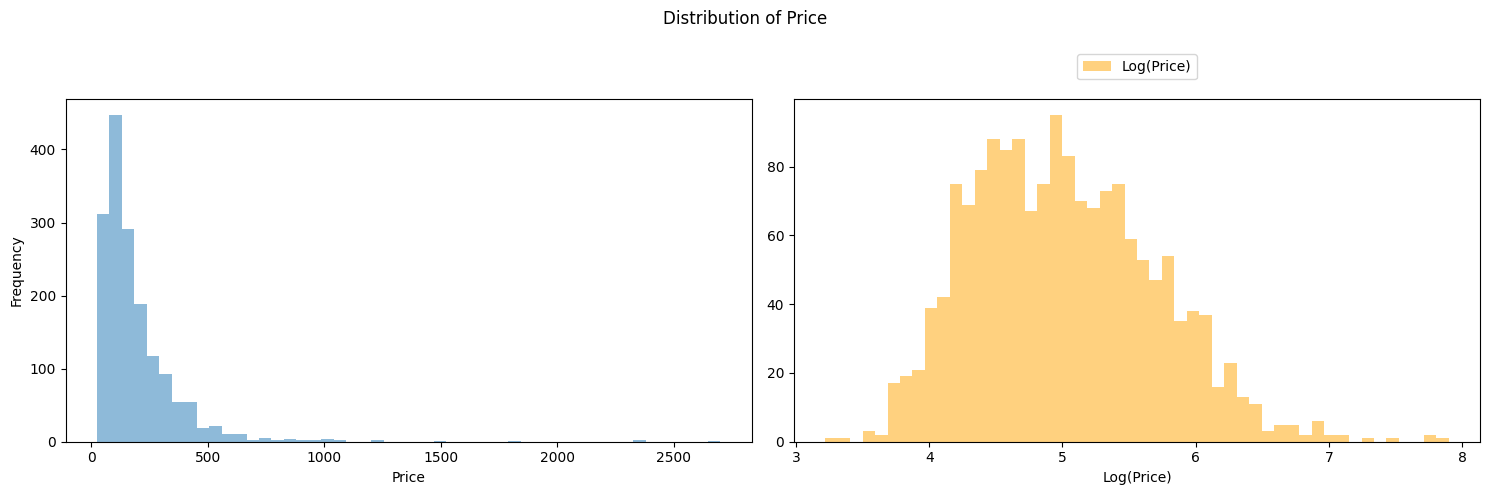

In [228]:
# split data
X = dublin_encoded_df.drop(['id_x', 'price'], axis=1)
y = dublin_encoded_df['price']

# log transform y variable(price)
y_log = np.log(y)
y_log.name = "log(price)"

# plot the raw y variable and log transformed y variable
fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # figure with 2 subplots

# Plot original price distribution
ax[0].hist(y, bins=50, alpha=0.5, label="Price")
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Frequency")

# Plot log-transformed price distribution
ax[1].hist(y_log, bins=50, color="orange", alpha=0.5, label="Log(Price)")
ax[1].set_xlabel("Log(Price)")

# Add legend
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))

# main title
plt.suptitle("Distribution of Price")

plt.tight_layout()
plt.show()

The raw prices are right-skewed, with most listings priced under £500, and a few very expensive outliers.  After log transformation, the distribution becomes more normal (bell-shaped) — making it better suited for regression models. Log transformation helps stabilize variance, reduce skewness, and improve model performance.

In [229]:
dublin_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174557 entries, 0 to 310083
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id_x                       174557 non-null  int64         
 1   listing_url                174557 non-null  object        
 2   name                       174557 non-null  object        
 3   description                174557 non-null  object        
 4   neighborhood_overview      174557 non-null  object        
 5   picture_url                174557 non-null  object        
 6   host_id                    174557 non-null  int64         
 7   host_response_time         174557 non-null  object        
 8   host_response_rate         174557 non-null  object        
 9   host_is_superhost          174557 non-null  object        
 10  host_listings_count        174557 non-null  float64       
 11  host_total_listings_count  174557 non-null  float64      

In [166]:
#dublin_merged_df.to_csv('dublin_merged_df.csv.gz', index=False, compression='gzip')

In [167]:
# load listings
#test_df = pd.read_csv('dublin_merged_df.csv.gz', compression='gzip')
#test_df.head()

,id_x,listing_url,name,description,neighborhood_overview,picture_url,host_id,host_response_time,host_response_rate,host_is_superhost,...,estimated_occupancy_l365d,estimated_revenue_l365d,instant_bookable,date,reviewer_id,comments,avg_rating,compound_scores,month,season
0,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-03-20,393348,We enjoyed our stay very much. The room was co...,4.827143,0.9849,3,Spring
1,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-03-28,444004,We have been here 4 nights. Stay in a home is ...,4.827143,0.9846,3,Spring
2,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-04-21,465058,Teresa and Hughie were great hosts. They were ...,4.827143,0.9836,4,Spring
3,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-05-13,490005,"No surprises, was as described. Very gracious...",4.827143,0.9412,5,Spring
4,44077,https://www.airbnb.com/rooms/44077,cosy comfortable Irish cottage twin,Our house is a cosy comfortable cottage with ...,I like our neighbourhood as there is no shorta...,https://a0.muscache.com/pictures/525706/050a3a...,193005,within a few hours,100%,t,...,234,17784.0,f,2011-05-17,520460,"Teresa was a lovely hostess, and we had a deli...",4.827143,0.9835,5,Spring


In [230]:
# Save dublin_encoded_df
dublin_encoded_df.to_csv('dublin_encoded_df.csv', index=False)

# Save dublin_aggregated_df
dublin_aggregated_df.to_csv('dublin_aggregated_df.csv', index=False)

**Collaborative-Filtering Models**

In [ ]:

# Split the data into train and test sets using scikit-learn's train_test_split
train_df, test_df = sklearn_train_test_split(dublin_merged_df[['reviewer_id', 'id_x', 'compound_scores']], test_size=0.2, random_state=42)

# Load train and test datasets with the rating scale (-1, 1)
reader = Reader(rating_scale=(-1, 1))
train_data = Dataset.load_from_df(train_df, reader)
test_data = Dataset.load_from_df(test_df, reader)

In [ ]:
# Convert train_data to Surprise’s trainset format
trainset = train_data.build_full_trainset()

In [ ]:
# Initialize and cross-validate BaselineOnly model
baseline_model = BaselineOnly()
cv_baseline = cross_validate(baseline_model, train_data, cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4085  0.4083  0.4125  0.4086  0.4110  0.4098  0.0017  
MAE (testset)     0.2923  0.2921  0.2948  0.2933  0.2933  0.2932  0.0010  
Fit time          2.10    1.19    1.25    0.98    1.00    1.31    0.41    
Test time         0.20    0.11    0.20    0.11    0.11    0.15    0.04    


**SlopeOne model**

In [ ]:
# Evaluate SlopeOne model
slope_one = SlopeOne()
cv_slopeone = cross_validate(slope_one, train_data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4171  0.4188  0.4179  0.4233  0.4218  0.4198  0.0024  
MAE (testset)     0.3016  0.3010  0.3023  0.3063  0.3049  0.3032  0.0020  
Fit time          2.23    2.28    0.96    0.92    0.93    1.46    0.65    
Test time         0.40    0.19    0.19    0.20    0.20    0.24    0.08    


**SVD Model**

In [ ]:
# Parameter tuning for SVD model
params = {
    'n_factors': [20, 50, 100],
    'n_epochs': [5, 10],
    'reg_all': [0.02, 0.05, 0.1],
    'lr_all': [0.002, 0.005, 0.01]
}
gridsearch_svd = GridSearchCV(SVD, param_grid=params, cv=5, measures=['rmse'], n_jobs=-1)
gridsearch_svd.fit(train_data)

In [ ]:
# Display best score and parameters
print("Best RMSE score from GridSearch:", gridsearch_svd.best_score["rmse"])
print("Best parameters for SVD model:", gridsearch_svd.best_params["rmse"])

Best RMSE score from GridSearch: 0.4099788088144001
Best parameters for SVD model: {'n_factors': 20, 'n_epochs': 10, 'reg_all': 0.1, 'lr_all': 0.01}


In [ ]:
final_model = SVD(n_factors=20,
                  n_epochs=10,
                  reg_all=0.1,
                  lr_all=0.01,
                  random_state=42)

final_model.fit(trainset)

In [ ]:
# Build testset and evaluate final model on test data
testset = test_data.build_full_trainset().build_testset()
predictions = final_model.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print("Final RMSE:", rmse)
print("Final MAE:", mae)

RMSE: 0.4097
MAE:  0.2958
Final RMSE: 0.40968830705480774
Final MAE: 0.29575457207472977


With a train RMSE of 0.375, test of 0.45 and a low MAE of 0.24, the model has a higher test RMSE.

**Save BaselineOnly model**

In [ ]:
# Initialize the BaselineOnly model
baseline_model = BaselineOnly()

# Cross-validate the model
cv_baseline = cross_validate(baseline_model, train_data, cv=5, verbose=True)

# Fit the model on the entire training set
baseline_model.fit(train_data.build_full_trainset())

# Save the fitted model to a file
joblib.dump(baseline_model, 'baseline_model.pkl')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4092  0.4084  0.4111  0.4113  0.4091  0.4098  0.0012  
MAE (testset)     0.2936  0.2933  0.2933  0.2931  0.2927  0.2932  0.0003  
Fit time          1.40    1.13    1.04    1.03    1.05    1.13    0.14    
Test time         0.21    0.13    0.11    0.12    0.11    0.14    0.03    
Estimating biases using als...


['baseline_model.pkl']

**Recommend Airbnb to Guests**

In [ ]:
from IPython.display import display, HTML, Image

def recommend_airbnbs(user_id, listings_df=dublin_merged_df):
    """
    Recommend 5 personalized Dublin Airbnb listings to the user based on sentiment scores.
    """

    # Get listings already rated by the user
    user_listings = dublin_merged_df[dublin_merged_df['reviewer_id'] == user_id]['id_x'].unique()

    # Get all listings
    all_listings = dublin_merged_df['id_x'].unique()

    # Identify listings not yet rated by the user for predictions
    listings_to_predict = list(set(all_listings) - set(user_listings))

    # Create matrix to predict listing ratings for unrated listings
    user_listing_pairs = [(user_id, listing_id, 0) for listing_id in listings_to_predict]

    # Get predictions for unrated listings
    predictions = baseline_model.test(user_listing_pairs)

    # Sort predictions by estimated rating and select top 5
    top_5_recs = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

    # Retrieve listing details for each recommendation
    top_5_listings = [listings_df[listings_df['id_x'] == rec.iid] for rec in top_5_recs]

    # Display recommended listings
    for idx, listing in enumerate(top_5_listings):
        # Display listing name as a clickable hyperlink
        listing_name_link = f'<a href="{listing.listing_url.iloc[0]}" target="_blank">{listing.description.iloc[0]}</a>'
        print(f'Recommendation #{idx + 1}:')
        display(HTML(listing_name_link))

        # Display listing image
        #img = Image(listing.picture_url.iloc[0], width=250)
        # display(img)

        print('\n')  # Line break between recommendations

recommend_airbnbs(user_id=44077)

Recommendation #1:




Recommendation #2:




Recommendation #3:




Recommendation #4:




Recommendation #5:
